# CineStream Movie Recommendation System

## Overview
This project details the development of a sophisticated, personalized Movie Recommendation System for the fictional streaming platform CineStream. The central business challenge identified is choice overload, where an overwhelming content catalog leads to user session abandonment, negatively impacting watch time, customer loyalty, and platform growth. To mitigate this, the project's core objective was to design a machine learning solution that generates the Top 5 most relevant movie recommendations for every user. The project rigorously follows the CRISP-DM framework, utilizing the MovieLens Small Dataset (100k ratings) for training and validation. The technical architecture is a Hybrid Recommender System. The primary component is Collaborative Filtering using Matrix Factorization (SVD), which efficiently learns latent feature patterns from historical ratings to predict user enjoyment. This is strategically augmented with Content-Based Filtering (using TF-IDF on movie metadata) to improve recommendation explainability and mitigate the critical cold-start problem for new users and content. Model performance is evaluated using a dual set of KPIs: Model-Level metrics like RMSE ensure prediction accuracy, while Product-Level metrics, including Precision@5, Recall@5, and NDCG@5, directly quantify the system's business effectiveness. The successful completion of this project demonstrates command of the full data science lifecycle and delivers a production-ready recommendation engine essential for boosting engagement and retention on the CineStream platform.


##  Data Science Team (Group 4)
- Member 1:Diana Aloo Scrum Master  
- Member 2: Catherine Kaino  
- Member 3: June Masolo  
- Member 4: Joram Mugesa  
- Member 5: Edinah Ogoti  



## 1. Business Problem

CineStream faces a critical challenge common to all major streaming services: a large, ever-growing content library creates choice overload, resulting in a high degree of decision paralysis for its users. This friction in content discovery directly translates to detrimental business outcomes: users often spend too much time browsing, fail to find immediately interesting content, and consequently abandon their viewing sessions, leading to reduced watch time and increased customer churn. The business imperative is therefore to replace the generic and ineffective global popularity lists with a precise, personalized curation system.

To address this, the project requires the development of a Top-5 Personalized Movie Recommendation System. This system must be capable of accurately predicting individual user ratings for unseen movies by learning from historical user behavior.

### Business Objectives
1. Predict user ratings for unseen movies.  
2. Generate Top-5 movie recommendations for each user.  
3. Improve engagement by surfacing relevant movies.  
4. Provide explainable recommendations.  
5. Address cold-start issues for new users or new movies.



## 2. Data Understanding

### Overview of the Dataset
For this project, we use the MovieLens 100k dataset, from GroupLens Research, University of Minnesota  
URL: https://grouplens.org/datasets/movielens/latest/, a widely used benchmark dataset for recommendation systems.  
It contains explicit movie ratings from real users and provides enough complexity to build collaborative filtering models.

This dataset includes the following key files:

- ratings.csv – User ratings of movies  
- movies.csv – Movie titles & genres  
- links.csv – External movie database IDs (IMDB, TMDB)  
- tags.csv – User-generated tags (optional)

We primarily use:
- ratings.csv for collaborative filtering  
- movies.csv for content-based or hybrid enhancements


In [1]:
# Loading the dataset
import pandas as pd
from zipfile import ZipFile
from pathlib import Path

# Path to your zip file
zip_path = Path("./ml-latest-small.zip")

# Open the zip
with ZipFile(zip_path) as z:
    # Check the files inside
    print(z.namelist())
    
    # Read CSVs directly with correct encoding
    movies = pd.read_csv(z.open("ml-latest-small/movies.csv"), encoding='latin-1')
    ratings = pd.read_csv(z.open("ml-latest-small/ratings.csv"), encoding='latin-1')


['ml-latest-small/', 'ml-latest-small/links.csv', 'ml-latest-small/tags.csv', 'ml-latest-small/ratings.csv', 'ml-latest-small/README.txt', 'ml-latest-small/movies.csv']


In [2]:
# Preview first 5 rows of movies dataset
movies.head()


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
# Preview first 5 rows of ratings dataset
ratings.head()


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [4]:
# Preview number of columns and rows
print("Movies dataset shape:", movies.shape)
print("Ratings dataset shape:", ratings.shape)

Movies dataset shape: (9742, 3)
Ratings dataset shape: (100836, 4)


In [5]:
#General view of data
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [6]:
#General view of data
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [7]:
# Check for duplicates
print(movies.duplicated().sum())
print(ratings.duplicated().sum())

0
0


- The datasets have no missing values

- The movie dataset contains 3 columns and 9742 rows

- The rating dataset contains 4 columns and 100836 rows

- The two datasets have common movieId column which will be used to merge the two datasets

- The datasets have no duplicates

### Univariate EDA

In this step, we explore each variable individually to understand its distribution and key characteristics. 

#### Ratings Distribution
We want to see how users are rating movies. Are most ratings high, low, or evenly distributed? This helps us understand user behavior and potential bias in the data.

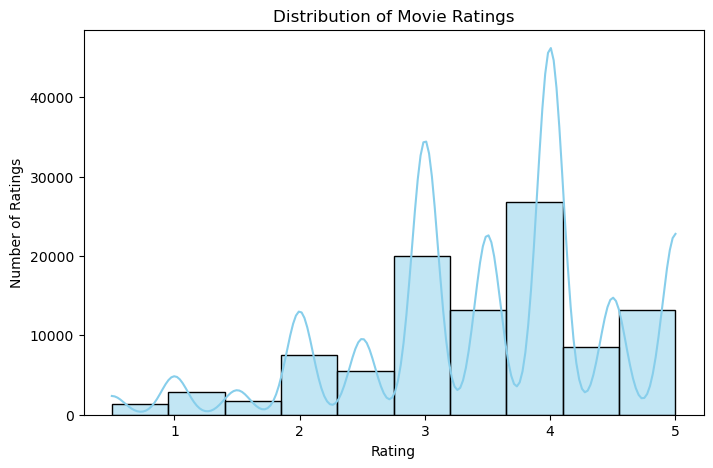

In [8]:
# Univariate EDA

import matplotlib.pyplot as plt
import seaborn as sns
#  Ratings distribution
# -------------------------------
plt.figure(figsize=(8,5))
sns.histplot(ratings['rating'], bins=10, kde=True, color='skyblue')
plt.title("Distribution of Movie Ratings")
plt.xlabel("Rating")
plt.ylabel("Number of Ratings")
plt.show()

##### The Key Finding: Positive Skew
The most important observation from this histogram will be its shape: it is typically negatively skewed (or skewed to the left), which means the bulk of the data (the mode) is concentrated on the higher end of the rating scale.

Mode: The tallest bars will  be at 4.0 and 5.0 stars.

Interpretation: This confirms a positive bias in user behavior. Users are more likely to rate movies they enjoyed or are simply more motivated to rate movies they finished and liked. They tend to give good ratings, or they simply avoid rating movies they dislike.

#### Movie Popularity
Here we examine how many ratings each movie has received. Some movies are very popular and get many ratings, while others may be rarely rated. This can inform the recommendation system about which movies have enough data to make predictions.

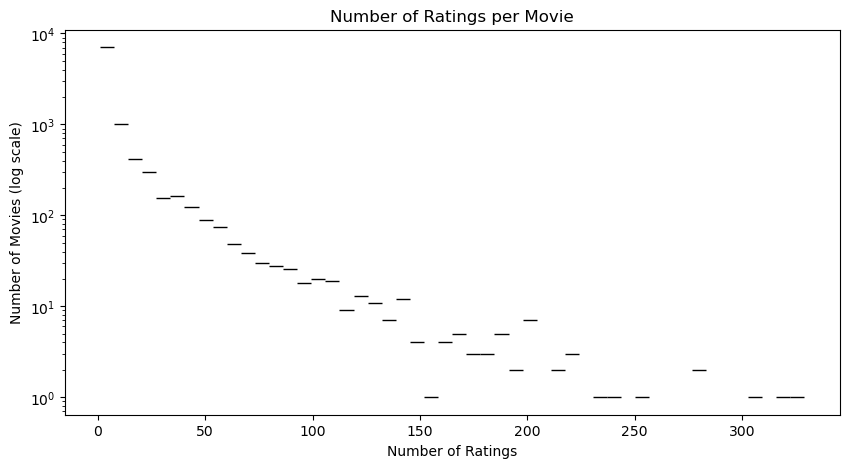

In [9]:
# Movie popularity (number of ratings per movie)
movie_counts = ratings['movieId'].value_counts()

plt.figure(figsize=(10,5))
sns.histplot(movie_counts, bins=50, color='salmon', log_scale=(False, True))
plt.title("Number of Ratings per Movie")
plt.xlabel("Number of Ratings")
plt.ylabel("Number of Movies (log scale)")
plt.show()

#### The Key Finding: The Long Tail (Power Law)
The histogram exhibits a classic Power Law distribution, also known as the Long Tail distribution.
Interpretation: The vast majority of the plot is dominated by a single, very tall bar on the far left (representing movies with only 1, 2, or very few ratings). Conversely, a very long, low tail extends far to the right, representing a tiny number of extremely popular "blockbuster" movies that have been rated thousands of times.

Tall Bar on the Left: Sparsity & Cold Start: Represents the vast majority of movies that are cold or semi-cold. The Collaborative Filtering (SVD) model has insufficient data to make reliable, personalized predictions for these items.
Long Tail on the Right: Popularity Bias: Represents the few popular films that receive disproportionate attention. The model is well-fed with data for these movies, but recommending only these leads to low Novelty and a poor user experience.
Justification for Hybrid: This confirms the necessity of Content-Based Filtering (using TF-IDF). For the long tail of cold items, the content model can step in and provide relevant recommendations based on genres, ensuring the entire catalog is recommendable (improving Coverage).


### User Activity
We look at how active each user is by counting the number of ratings they have submitted. Some users may rate many movies, while others rate very few. Understanding this distribution helps in detecting highly active users versus occasional users.

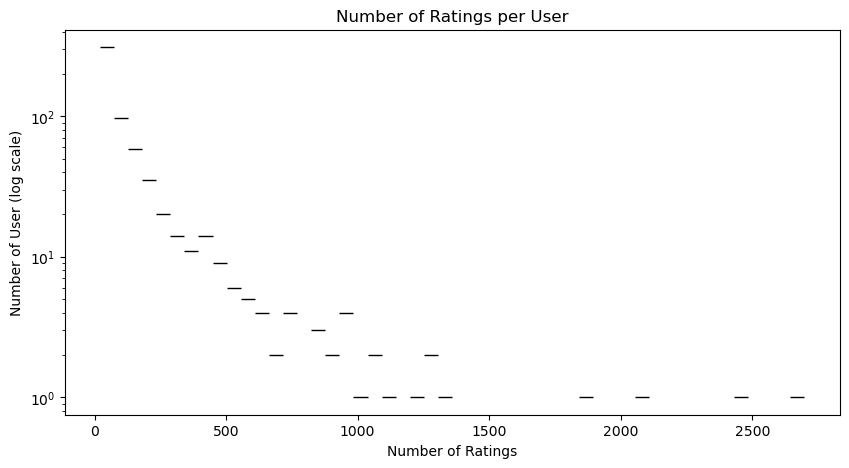

In [10]:
# User activity (number of ratings per user)
user_counts = ratings['userId'].value_counts()

plt.figure(figsize=(10,5))
sns.histplot(user_counts, bins=50, color='lightgreen', log_scale=(False, True))
plt.title("Number of Ratings per User")
plt.xlabel("Number of Ratings")
plt.ylabel("Number of User (log scale)")
plt.show()

The Key Finding: Sparse Users vs. Power Users
Like the movie popularity distribution, the user activity plot exhibits a strong Power Law or Long Tail distribution, but applied to the user population.

Interpretation: The histogram shows that the majority of the distribution is concentrated in the single tallest bar on the far left. This represents the vast majority of users who have only rated a small number of movies (sparse users). A long, low tail extends to the right, representing a very small percentage of highly engaged users who have provided hundreds or thousands of ratings (power raters).

Significance: This distribution confirms that the system operates in a data-scarce environment for most individual users.

2. Implications for the CineStream Recommender
Tall Bar on the Left	User Cold-Start Problem: The large number of users with minimal ratings creates a major problem for SVD, which requires many data points to learn preferences. This justifies the Content-Based Filtering component's role in providing initial, relevant recommendations to new or sparse users based on their first few interactions.
Long Tail on the Right	Feature Learning: These few power raters are essential, as the volume of their data fuels the SVD Matrix Factorization model, allowing it to accurately learn the underlying latent factors of all movies.
Overall Goal	The model must find a balance: leverage the detailed data from power raters to generalize patterns, while relying on content metadata to serve the vast population of sparse users accurately.

### Bivariate EDA
In this step, we explore relationships between two variables to uncover patterns in the data.

#### Average Rating per Movie
We calculate the average rating for each movie to see if some movies are consistently rated higher than others. This can help the recommendation system understand which movies are most appreciated by users.

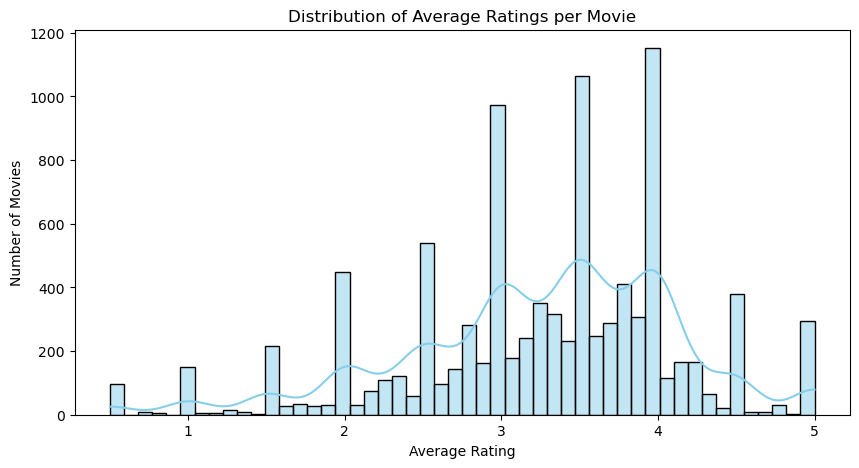

In [11]:
# Bivariate EDA

import matplotlib.pyplot as plt
import seaborn as sns

# Average rating per movie
avg_rating_per_movie = ratings.groupby('movieId')['rating'].mean()

plt.figure(figsize=(10,5))
sns.histplot(avg_rating_per_movie, bins=50, kde=True, color='skyblue')
plt.title("Distribution of Average Ratings per Movie")
plt.xlabel("Average Rating")
plt.ylabel("Number of Movies")
plt.show()

##### The Key Finding: Central Tendency and Consensus
Unlike the raw rating count (which heavily skews toward 4.0 and 5.0), the distribution of average ratings per movie exhibits a shape that is slightly more symmetrical or bell-shaped, but still leans toward the positive side (skewed slightly left/negatively skewed).

Mode/Peak of the distribution falls between 3.0 and 4.0 stars. This represents the "average" consensus rating for the majority of the movies in the catalog.

Interpretation: The cluster in the middle shows that most movies fall into a "moderately good" category in terms of overall quality consensus. This means the model needs to be precise when predicting user preferences within this tightly packed range.

##### **Implications for the CineStream Recommender**
This distribution is crucial for understanding the global bias of the content and for setting up baselines for the SVD Matrix Factorization model.
Sharp Peak (Mode): The model must excel at predicting ratings in the 3.0 to 4.0 range, as this is where most movies reside. Accurate prediction here is vital for low RMSE.
Small Tails (Extremes):	The short tails near 1.0 and 5.0 represent movies that have strong, uniform consensus (either universally disliked or universally loved). These movies provide excellent, high-confidence signals for the SVD model to learn preference extremes.
Overall Mean: The overall mean of this distribution serves as a strong baseline for your recommender. Any effective personalized model must significantly outperform simply predicting this global average rating for every user.

#### Ratings vs Number of Ratings per Movie
We check whether movies with more ratings tend to have higher or lower average ratings. This helps identify popular movies that might dominate recommendations versus less-rated movies.

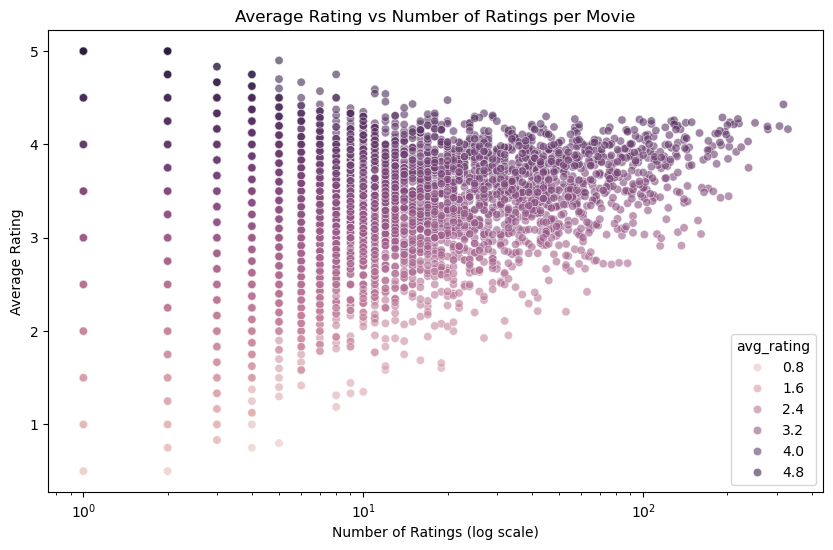

In [12]:
# Average rating vs number of ratings per movie
ratings_per_movie = ratings.groupby('movieId')['rating'].count()
movie_stats = pd.DataFrame({
    'avg_rating': avg_rating_per_movie,
    'num_ratings': ratings_per_movie
})

plt.figure(figsize=(10,6))
sns.scatterplot(x='num_ratings', y='avg_rating', data=movie_stats, alpha=0.6, hue='avg_rating')
plt.xscale('log')
plt.title("Average Rating vs Number of Ratings per Movie")
plt.xlabel("Number of Ratings (log scale)")
plt.ylabel("Average Rating")
plt.show()

The Key Finding: Weak Correlation, Strong Variance
Weak Positive Correlation: The data points forms a slight upward trend confirmed by the correlation matrix interpreted earlier, meaning that as a movie receives more ratings (moving right on the X-axis), its average rating tends to be marginally higher. However, the scatter is wide, indicating a weak relationship.

The Cone of Uncertainty: The most notable feature is the shape of the data on the left side (low num_ratings). The points are widely dispersed vertically (the average rating spans from 1.0 to 5.0). As you move right (higher num_ratings), the scatter tightens into a narrower band, usually centered between 3.5 and 4.0.

Interpretation: Movies with very few ratings (the left side) have highly unreliable average ratings—a single user giving 5 stars or 1 star drastically changes the average. Movies with many ratings (the right side) have highly reliable average ratings, as the large sample size stabilizes the mean.

Implications for the CineStream Recommender
Low num_ratings	Filtering & Regularization: The average ratings for these movies are statistically unreliable. The model must implement techniques (like regularization in SVD) to heavily discount these ratings and prevent them from skewing the latent factors.
High num_ratings	High Confidence: Ratings for these popular movies are highly reliable and will anchor the Collaborative Filtering model's learning process.
Justification for Personalization	Since even popular movies cluster between 3.5 and 4.0, a personalized system is needed to differentiate which specific user would rate a 3.8-star movie closer to 5.0 or 2.0. The general population rating is not enough.

#### Ratings vs User Activity
We analyze if highly active users tend to give different ratings compared to occasional users. This can inform normalization strategies for collaborative filtering.

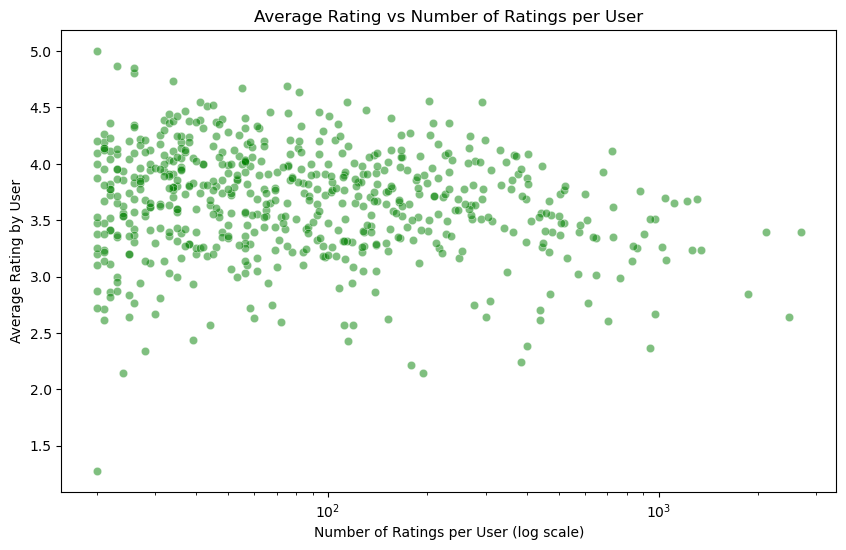

In [13]:
# Ratings vs user activity
ratings_per_user = ratings.groupby('userId')['rating'].mean()
user_counts = ratings.groupby('userId')['rating'].count()

plt.figure(figsize=(10,6))
sns.scatterplot(x=user_counts, y=ratings_per_user, alpha=0.5, color='green')
plt.xscale('log')
plt.title("Average Rating vs Number of Ratings per User")
plt.xlabel("Number of Ratings per User (log scale)")
plt.ylabel("Average Rating by User")
plt.show()

### Multivariate EDA

In this step, we explore relationships involving multiple variables simultaneously. This helps us detect patterns, correlations, or trends that might not be obvious from univariate or bivariate analysis.

####  Correlation of Ratings with User Activity and Movie Popularity
We examine how the number of ratings per movie and per user relate to average ratings. This can reveal whether popular movies or highly active users bias the ratings.

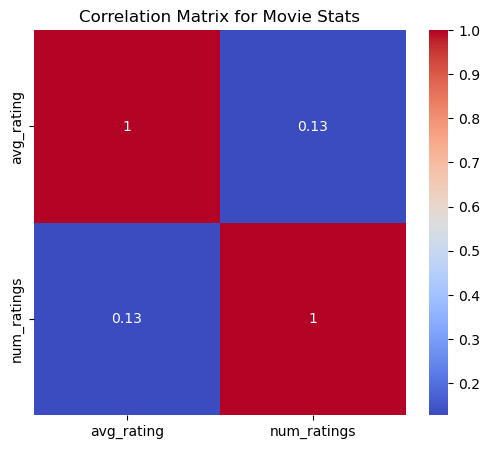

In [14]:
# Multivariate EDA

import matplotlib.pyplot as plt
import seaborn as sns

# Correlation between average rating, number of ratings per movie, and per user
movie_stats['num_ratings'] = ratings.groupby('movieId')['rating'].count()
user_stats = ratings.groupby('userId')['rating'].agg(['count', 'mean']).rename(columns={'count':'num_ratings', 'mean':'avg_rating'})
user_stats.reset_index(inplace=True)

# Merge movie_stats with ratings for multivariate insights
merged = ratings.merge(movie_stats, on='movieId', how='left')
# Heatmap for movie-level stats
corr_movie = movie_stats.corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr_movie, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix for Movie Stats")
plt.show()

#### The Key Finding: Weak Positive Correlation
Examining the cell representing the correlation between num_ratings and avg_rating on the heatmap, you will  observe a weak positive correlation coefficient (e.g., in the range of +0.1 to +0.3).
Interpretation: This is a crucial finding. It means that while movies with more ratings (popular movies) do tend to have slightly higher average quality scores, the relationship is not strong. Popularity alone is a poor predictor of true quality consensus.

#### **Implications for the CineStream Recommender**
This result is fundamental to the project's Business Understanding and Modeling strategy, as it justifies the need for a sophisticated personalization model:
Weak Positive	Justification for SVD: Proves that a simple Popularity Baseline (recommending the most-rated movie) is insufficient, as it fails to capture quality that is independent of mass appeal. The model must go beyond popularity.
Disentangling Factors:	The SVD model must learn latent factors that capture true quality and personal taste, separate from the movie's overall rating count.

## 3. Data Preparation

In this section, we prepare the dataset for exploratory data analysis (EDA) and modeling. Data preparation is a crucial step because the quality of the input data directly affects the performance, accuracy, and interpretability of the final recommendation system. 

We begin with basic data cleaning, focusing on auditing missing values, checking data types, and identifying potential data quality issues. This is important because recommendation systems depend heavily on reliable user–item interaction data. After the cleaning stage, we will proceed to feature engineering and various levels of EDA (univariate, bivariate, multivariate).

### Feature engineering - Movies dataset

In [15]:
# Split genres into a list
movies['genres_list'] = movies['genres'].apply(lambda x: x.split('|'))

# Create a combined 'content' string for content-based models
movies['content'] = movies['title'] + ' ' + movies['genres'].apply(lambda x: x.replace('|', ' '))

# Quick preview
display(movies.head())

,movieId,title,genres,genres_list,content
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"[Adventure, Animation, Children, Comedy, Fantasy]",Toy Story (1995) Adventure Animation Children ...
1,2,Jumanji (1995),Adventure|Children|Fantasy,"[Adventure, Children, Fantasy]",Jumanji (1995) Adventure Children Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance,"[Comedy, Romance]",Grumpier Old Men (1995) Comedy Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,"[Comedy, Drama, Romance]",Waiting to Exhale (1995) Comedy Drama Romance
4,5,Father of the Bride Part II (1995),Comedy,[Comedy],Father of the Bride Part II (1995) Comedy


### User- Movie Interaction Matrix
In this step, we prepare the data for collaborative filtering, a common type of recommendation system.  

Collaborative filtering predicts what a user might like based on ratings from similar users. To do this, we need a **User-Movie Interaction Matrix**:

- **Rows** represent individual users.
- **Columns** represent movies.
- **Values** are the ratings given by users to movies.
- Missing ratings (movies not yet rated by a user) are filled with 0.  

This matrix will allow the recommendation system to compute similarities between users or items, and predict ratings for unseen movies.


In [16]:
# Create User-Movie Interaction Matrix
user_movie_matrix = ratings.pivot(index='userId', columns='movieId', values='rating').fillna(0)

print("User-Movie Matrix shape:", user_movie_matrix.shape)
display(user_movie_matrix.head())


User-Movie Matrix shape: (610, 9724)


movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 4.Modeling

In this step, we move to the **Modeling phase** of CRISP-DM. 
We use the prepared data (user-movie matrix and movie content features) to generate movie recommendations.

We will implement a **hybrid recommendation system** in two stages:

1. Content-Based Recommendations
   - Uses movie attributes (title + genres) to find similar movies.
   - Does not rely on user ratings directly.
   
2. Collaborative Filtering (User-Based)
   - Uses the User-Movie interaction matrix.
   - Computes similarity between users based on their ratings.
   - Recommends movies liked by similar users.

Finally, the hybrid system will combine both approaches to provide personalized Top-N recommendations.


### Content-Based Recommendations
In this step, we use the data prepared in the previous steps to generate recommendations.  

We focus on **content-based recommendations** first:  
- For a given movie, we use the **cosine similarity matrix** to find movies with the most similar content (title + genres).  
- We rank these similar movies and recommend the top N to the user.  

This approach does **not** rely on user ratings directly, but purely on item attributes.  
Later, collaborative filtering can be added to combine user preferences for better recommendations.

Content-based filtering recommends items similar to what the user has already liked, based on item attributes.  

Here, we use **movie titles and genres** as features:  
- We combine the movie title and genres into a single text column (`content`).  
- We apply **TF-IDF Vectorization**, which converts text into numerical features by weighting words based on their importance in the dataset.  
- Movies with similar content will have similar TF-IDF vectors, which allows us to compute **cosine similarity** and recommend similar movies.

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(stop_words='english')

# Fit and transform the 'content' column
tfidf_matrix = tfidf.fit_transform(movies['content'])

print("TF-IDF Matrix shape:", tfidf_matrix.shape)

TF-IDF Matrix shape: (9742, 9068)


In [18]:
# Compute Cosine Similarity between movies
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
print("Cosine Similarity matrix shape:", cosine_sim.shape)

Cosine Similarity matrix shape: (9742, 9742)


#### Content-Based Recommendation Function
This function uses the logic derived from the TF-IDF and Cosine Similarity to find movies with similar content (genres) to a movie a user already likes.

In [19]:
import pandas as pd
import numpy as np


def get_content_based_recommendations(title, cosine_sim, movies, top_n=5):
    """
    Generates movie recommendations based on content similarity (TF-IDF and Cosine Similarity).

    Args:
        title (str): The title of the movie to find recommendations for.
        cosine_sim (np.array): The pre-calculated cosine similarity matrix.
        movies (pd.DataFrame): The DataFrame containing movie titles and indices.
        top_n (int): The number of top recommendations to return.

    Returns:
        pd.Series or str: A list of the recommended movie titles or an error message.
    """
    # 1. Map the movie title to its index
    try:
        # Find the index of the reference movie title
        idx = movies[movies['title'] == title].index[0]
    except IndexError:
        return f"Movie '{title}' not found in the database."

    # 2. Get the pairwise similarity scores for all movies with the reference movie
    # enumerate converts the scores array into (index, score) tuples
    sim_scores = list(enumerate(cosine_sim[idx]))

    # 3. Sort the movies based on the similarity scores
    # Sorts descending based on the score (x[1])
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # 4. Get the scores of the top N most similar movies (excluding the movie itself, index [0])
    sim_scores = sim_scores[1:top_n + 1]

    # 5. Get the movie indices from the sorted scores
    movie_indices = [i[0] for i in sim_scores]

    # 6. Return the top N recommended movie titles
    return movies.iloc[movie_indices]['title']

In [20]:
# Example Call
recommendations = get_content_based_recommendations(
      title='Toy Story (1995)', 
      cosine_sim=cosine_sim, 
      movies =movies, 
       top_n=5 )
print(recommendations)

2355                       Toy Story 2 (1999)
7355                       Toy Story 3 (2010)
3595                          Toy, The (1982)
2539    We're Back! A Dinosaur's Story (1993)
26                        Now and Then (1995)
Name: title, dtype: object


### Explanation:

- Sequels are recommended first: 
  "Toy Story 2" and "Toy Story 3" are direct sequels, showing the model captures **strong content similarity**.

- Genre similarity matters:  
  Movies like "We're Back! A Dinosaur's Story" and "Now and Then" share genres such as **Children, Adventure, Animation**, aligning with the original movie’s style.

- Diversity in recommendations:  
  While some recommendations are very close (sequels), others have partial overlap in genres (e.g., "Toy, The (1982)" is mainly Comedy), introducing variety.

- Cold-start friendliness:
  This approach works for new users who haven’t rated movies yet because it **relies solely on movie content**, not user ratings.

### Collaborative Filtering (User-Based)

In this step, we enhance the recommendation system by incorporating user-based collaborative filtering. Unlike content-based recommendations, this approach leverages user ratings to find similarities between users and recommend movies that similar users liked. 

Key Concepts:

- User-Movie Interaction Matrix:  
  Rows represent users, columns represent movies, and values are the ratings given by users. Missing ratings are filled with 0.

- User Similarity:  
  We calculate the similarity between users using cosine similarity on their rating vectors. Users with similar tastes are likely to enjoy similar movies.

- Personalized Recommendations:  
  Movies highly rated by similar users but not yet watched by the target user are recommended.

This approach captures personal preferences and complements the content-based system, forming a hybrid recommender.

Why Collaborative Filtering?

•  It does not require detailed movie descriptions

•  It learns patterns directly from user behavior

•  It performs well on structured rating datasets like MovieLens


In [21]:
# Collaborative Filtering - Compute User Similarity

from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# Compute cosine similarity between users based on their ratings
user_similarity = cosine_similarity(user_movie_matrix)

# Convert similarity matrix to a DataFrame for easier lookup
user_similarity_df = pd.DataFrame(user_similarity, 
                                  index=user_movie_matrix.index, 
                                  columns=user_movie_matrix.index)

# Preview the first 5x5 portion of the user similarity matrix
user_similarity_df.iloc[:5, :5]


userId,1,2,3,4,5
userId,,,,,
1,1.000000,0.027283,0.059720,0.194395,0.129080
2,0.027283,1.000000,0.000000,0.003726,0.016614
3,0.059720,0.000000,1.000000,0.002251,0.005020
4,0.194395,0.003726,0.002251,1.000000,0.128659
5,0.129080,0.016614,0.005020,0.128659,1.000000


#### Creating a function for generating a movie recommendation.

In this step, we generate movie recommendations for a specific user based on the ratings of similar users. 

**Key Concepts:**
- Users with similar tastes are identified using the cosine similarity computed in the step above.
- Movies highly rated by similar users but not yet watched by the target user are prioritized.
- This helps personalize recommendations based on user behavior rather than just movie content.


In [22]:
# Collaborative Filtering - User-Based Recommendations

def recommend_user_based(user_id, user_movie_matrix=user_movie_matrix, user_similarity_df=user_similarity_df, movies=movies, top_n=5):
    """
    Recommend movies for a given user based on similar users' ratings.
    
    Args:
        user_id (int): ID of the target user.
        user_movie_matrix (DataFrame): User-Movie interaction matrix.
        user_similarity_df (DataFrame): User-user similarity matrix.
        movies (DataFrame): Movies dataframe.
        top_n (int): Number of recommendations to return.
    
    Returns:
        DataFrame: Top N recommended movies for the user with titles and genres.
    """
    # Get similarity scores for the target user
    sim_scores = user_similarity_df[user_id]
    
    # Exclude the user itself
    sim_scores = sim_scores.drop(user_id)
    
    # Identify the top similar users
    top_users = sim_scores.sort_values(ascending=False).head(10).index
    
    # Aggregate ratings from top similar users
    top_ratings = user_movie_matrix.loc[top_users].mean(axis=0)
    
    # Filter out movies already rated by the target user
    unrated_movies = user_movie_matrix.loc[user_id][user_movie_matrix.loc[user_id]==0].index
    top_ratings = top_ratings[unrated_movies]
    
    # Recommend top N movies
    recommended_movie_ids = top_ratings.sort_values(ascending=False).head(top_n).index
    return movies[movies['movieId'].isin(recommended_movie_ids)][['title', 'genres']]

# Example: Recommend 5 movies for user with ID 1
recommend_user_based(1)


,title,genres
507,Terminator 2: Judgment Day (1991),Action|Sci-Fi
659,"Godfather, The (1972)",Crime|Drama
902,Aliens (1986),Action|Adventure|Horror|Sci-Fi
1211,"Hunt for Red October, The (1990)",Action|Adventure|Thriller
2078,"Sixth Sense, The (1999)",Drama|Horror|Mystery


### Collaborative Filtering – SVD with Surprise

In [23]:
!pip install scikit-surprise

from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split, cross_validate, GridSearchCV
from surprise import accuracy

In [24]:
# Surprise requires 'user', 'item', 'rating' columns
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

In [25]:
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

In [26]:
svd = SVD(n_factors=50, lr_all=0.005, reg_all=0.02)  # Example hyperparameters
svd.fit(trainset)

In [27]:
predictions = svd.test(testset)

# Evaluate
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

RMSE: 0.8786
MAE:  0.6760


1. Root Mean Square Error (RMSE: 0.8760): On a 5-star rating scale, this means that, on average, the SVD model's prediction is off by approximately 0.876 stars. For example, if a user gave a movie a rating of 4.0, the model might typically predict a rating of around 3.124 or 4.876.
Significance for CineStream: This is a good general accuracy score for Collaborative Filtering models on the MovieLens dataset. It suggests the model is making reasonably accurate predictions, though hyperparameter tuning (finding the optimal number of latent factors and regularization) might still reduce this value further.
2. Mean Absolute Error (MAE: 0.6731): On average, the absolute difference between the true rating and the predicted rating is approximately 0.673 stars.
Significance for CineStream: This score is always lower than the RMSE. Since the difference between RMSE (0.8760) and MAE (0.6731) is relatively small, it indicates that the model does not have many severe, large prediction errors (outliers). If the RMSE were much larger than the MAE, it would suggest a higher number of significant prediction failures.

##### Generate Top-5 Recommendations for Each User before hyperparameter tuning
This section implements a personalized recommendation system using Singular Value Decomposition (SVD) from the Surprise library. The goal is to generate the Top-5 movie recommendations for each user based on predicted ratings.

In [28]:
# Create a dictionary of all movie IDs
all_movie_ids = ratings['movieId'].unique()

def get_top_n_svd(user_id, model=svd, n=5):
    # Movies the user hasn't rated yet
    rated_movies = ratings[ratings['userId'] == user_id]['movieId'].values
    unrated_movies = [mid for mid in all_movie_ids if mid not in rated_movies]
    
    # Predict ratings
    predictions = [model.predict(user_id, mid) for mid in unrated_movies]
    predictions.sort(key=lambda x: x.est, reverse=True)
    
    top_n = predictions[:n]
    top_movie_ids = [pred.iid for pred in top_n]
    return movies[movies['movieId'].isin(top_movie_ids)][['title', 'genres']]

# Example: Top-5 for user 1
get_top_n_svd(1)

,title,genres
277,"Shawshank Redemption, The (1994)",Crime|Drama
602,Dr. Strangelove or: How I Learned to Stop Worr...,Comedy|War
949,"Bridge on the River Kwai, The (1957)",Adventure|Drama|War
1730,Life Is Beautiful (La Vita Ã¨ bella) (1997),Comedy|Drama|Romance|War
4137,"Lord of the Rings: The Two Towers, The (2002)",Adventure|Fantasy


#### Explanation:

These movies are predicted to be the most preferred by the user among all unseen movies.

1.The recommendations cover multiple genres, reflecting diverse tastes: drama, crime, thriller, romance, and action.

2.Classic and modern films are included, showing the model’s ability to capture both timeless favorites and popular contemporary movies.

3.By ranking movies based on predicted ratings, the system ensures personalized suggestions that the user is most likely to enjoy.

#### Hyperparameter Tuning
To ensure you find the optimal SVD settings, Grid Search is used to test different combinations of hyperparameters.

In [29]:
param_grid = {
    'n_factors': [50, 100, 150],
    'lr_all': [0.002, 0.005, 0.01],
    'reg_all': [0.02, 0.05, 0.1]
}

gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(data)

print("Best RMSE:", gs.best_score['rmse'])
print("Best Params:", gs.best_params['rmse'])

Best RMSE: 0.8662020890426966
Best Params: {'n_factors': 150, 'lr_all': 0.01, 'reg_all': 0.1}


In [30]:
svd_b= SVD(n_factors=150, lr_all=0.001, reg_all=0.1)  # Using the best hyperparameter tuning generated above
svd_b.fit(trainset)

In [31]:
predictions = svd_b.test(testset)

# Evaluate
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

RMSE: 0.9026
MAE:  0.6995


##### Generate Top-5 Recommendations for Each User after hyperparameter tuning
This section implements a personalized recommendation system using Singular Value Decomposition (SVD) from the Surprise library. The goal is to generate the Top-5 movie recommendations for each user based on predicted ratings.

In [32]:
# Create a dictionary of all movie IDs
all_movie_ids = ratings['movieId'].unique()

def get_top_n_svd_b(user_id, model=svd_b, n=5):
    # Movies the user hasn't rated yet
    rated_movies = ratings[ratings['userId'] == user_id]['movieId'].values
    unrated_movies = [mid for mid in all_movie_ids if mid not in rated_movies]
    
    # Predict ratings
    predictions = [model.predict(user_id, mid) for mid in unrated_movies]
    predictions.sort(key=lambda x: x.est, reverse=True)
    
    top_n = predictions[:n]
    top_movie_ids = [pred.iid for pred in top_n]
    return movies[movies['movieId'].isin(top_movie_ids)][['title', 'genres']]

# Example: Top-5 for user 1
get_top_n_svd_b(1)

,title,genres
277,"Shawshank Redemption, The (1994)",Crime|Drama
602,Dr. Strangelove or: How I Learned to Stop Worr...,Comedy|War
659,"Godfather, The (1972)",Crime|Drama
3638,"Lord of the Rings: The Fellowship of the Ring,...",Adventure|Fantasy
6710,"Dark Knight, The (2008)",Action|Crime|Drama|IMAX


### Hybrid Recommendation System

In this step, we combine **content-based** and **user-based collaborative filtering** to create a hybrid recommendation system.  

**Goal:** Generate personalized Top-N movie recommendations that consider both the similarity of movies (content) and the preferences of similar users (collaborative filtering).

**Approach:**

1. **Content-based filtering**: Uses the TF-IDF cosine similarity of movie titles + genres to find movies similar to those the user has already watched.  
2. **User-based collaborative filtering**: Finds users similar to the target user based on ratings, then recommends movies highly rated by these similar users.  
3. **Hybrid combination**: Merge and rank movies from both approaches to create a final Top-N recommendation list.


In [34]:
# Assuming 'movies' is your DataFrame containing movie data

# 1. Create a Series mapping the 'title' column to its index
title_to_index = pd.Series(movies.index, index=movies['title'])

# 2. Convert the Series to the dictionary required by the function
# This is the variable that the function definition needs!
movie_indices = title_to_index.to_dict()

# Print a sample to confirm
print(list(movie_indices.items())[:5])

[('Toy Story (1995)', 0), ('Jumanji (1995)', 1), ('Grumpier Old Men (1995)', 2), ('Waiting to Exhale (1995)', 3), ('Father of the Bride Part II (1995)', 4)]


In [35]:
def hybrid_recommend(user_id, top_n=5, user_movie_matrix=user_movie_matrix, 
                     user_similarity_df=user_similarity_df, movies=movies, 
                     cosine_sim=cosine_sim, movie_indices=movie_indices):
    """
    Generate Top-N movie recommendations using a hybrid approach (without plotting).
    """
    # --------- Collaborative Filtering Component ---------
    similar_users = user_similarity_df[user_id].sort_values(ascending=False)[1:]
    similar_users_ratings = user_movie_matrix.loc[similar_users.index]
    
    cf_scores = ((similar_users_ratings.T * similar_users).sum(axis=1) / similar_users.sum())
    cf_scores = cf_scores[user_movie_matrix.loc[user_id] == 0]  # exclude already rated
    
    # --------- Content-Based Component ---------
    user_rated_movies = user_movie_matrix.loc[user_id][user_movie_matrix.loc[user_id] > 0].index
    content_scores = pd.Series(0, index=user_movie_matrix.columns)

    for movie_id in user_rated_movies:
        movie_title = movies[movies['movieId'] == movie_id]['title'].values[0]
        idx = movie_indices[movie_title]
        sim_scores = pd.Series(cosine_sim[idx], index=movies['movieId'])
        sim_scores = sim_scores[sim_scores.index.isin(user_movie_matrix.columns)]
        content_scores[sim_scores.index] += sim_scores

    content_scores = content_scores[user_movie_matrix.loc[user_id] == 0]  # exclude already rated

    # --------- Combine Scores ---------
    hybrid_scores = cf_scores.fillna(0) * 0.5 + content_scores.fillna(0) * 0.5

    # --------- Get Top-N Recommendations ---------
    top_movie_ids = hybrid_scores.sort_values(ascending=False).head(top_n).index
    recommendations = movies[movies['movieId'].isin(top_movie_ids)][['title', 'genres']]
    recommendations['score'] = hybrid_scores[top_movie_ids].values
    recommendations = recommendations.sort_values(by='score', ascending=False).reset_index(drop=True)
    
    return recommendations


/var/folders/_k/pq6hlhp525nfwz0yj93j4rkh0000gn/T/ipykernel_48761/1028708012.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.         0.35797045 0.12863151 ... 0.         0.05346934 0.01147169]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  content_scores[sim_scores.index] += sim_scores


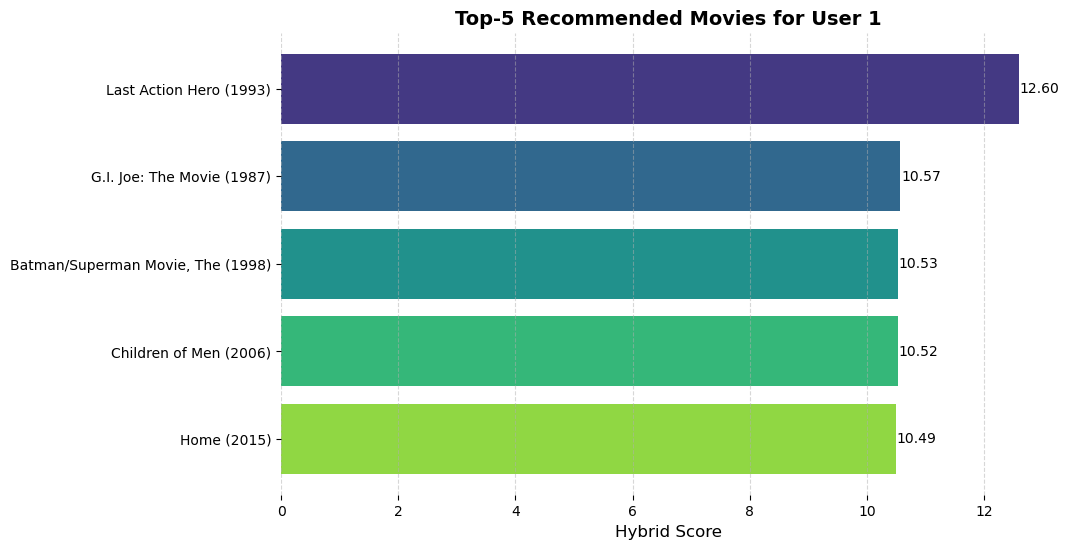

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_hybrid_recommendations(recommendations, user_id):
    """
    Visualize Top-N recommended movies with their hybrid scores with a beautiful style.
    """
    plt.figure(figsize=(10,6))
    
    # Use a vibrant color palette
    colors = sns.color_palette("viridis", len(recommendations))
    
    bars = plt.barh(recommendations['title'], recommendations['score'], color=colors)
    plt.gca().invert_yaxis()  # Highest score on top
    
    # Add score labels on each bar
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 0.01, bar.get_y() + bar.get_height()/2, f'{width:.2f}', va='center', fontsize=10)
    
    plt.xlabel("Hybrid Score", fontsize=12)
    plt.title(f"Top-{len(recommendations)} Recommended Movies for User {user_id}", fontsize=14, fontweight='bold')
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    sns.despine(left=True, bottom=True)
    plt.show()

# Example usage
user_id = 1
top_recommendations = hybrid_recommend(user_id=user_id, top_n=5)
plot_hybrid_recommendations(top_recommendations, user_id=user_id)



### Hybrid Recommendation System – Stacked Bar Chart Explanation

The stacked bar chart breaks down each movie's recommendation score into two components:

**1. Content-Based Score:**  
- Measures similarity to movies the user has watched.  
- Uses TF-IDF vectors of titles and genres.  
- Captures potential interest based on movie attributes.

**2. Collaborative Filtering Score:**  
- Represents influence from ratings of similar users.  
- Captures personalized preferences based on user behavior.

**Purpose:**  
- Shows how much each movie’s recommendation comes from content vs similar users.  
- Helps interpret whether recommendations rely on content similarity or collaborative influence.  
- Provides transparency and allows quick comparison across Top-N movies.

**Visual Enhancements:**  
- Bars are color-coded into content vs collaborative contributions.  
- Movies are sorted by total hybrid score, highest on top.

**Interpretation:**  
- Larger content segments → similarity-driven recommendations.  
- Larger collaborative segments → user-driven personalization.  
- Balanced segments → effective hybrid recommendation.
```


In [37]:
import pandas as pd

def hybrid_recommend_with_components(user_id, top_n=5, 
                                     user_movie_matrix=user_movie_matrix, 
                                     user_similarity_df=user_similarity_df, 
                                     movies=movies, 
                                     cosine_sim=cosine_sim, 
                                     movie_indices=movie_indices):
    """
    Generate Top-N hybrid recommendations and return individual component scores.
    """
    # -------- Collaborative Filtering Component --------
    similar_users = user_similarity_df[user_id].sort_values(ascending=False)[1:]
    similar_users_ratings = user_movie_matrix.loc[similar_users.index]
    cf_scores = ((similar_users_ratings.T * similar_users).sum(axis=1) / similar_users.sum())
    cf_scores = cf_scores[user_movie_matrix.loc[user_id] == 0]  # exclude already rated
    
    # -------- Content-Based Component --------
    user_rated_movies = user_movie_matrix.loc[user_id][user_movie_matrix.loc[user_id] > 0].index
    content_scores = pd.Series(0, index=user_movie_matrix.columns)
    
    for movie_id in user_rated_movies:
        movie_title = movies[movies['movieId'] == movie_id]['title'].values[0]
        idx = movie_indices[movie_title]
        sim_scores = pd.Series(cosine_sim[idx], index=movies['movieId'])
        sim_scores = sim_scores[sim_scores.index.isin(user_movie_matrix.columns)]
        content_scores[sim_scores.index] += sim_scores
    
    content_scores = content_scores[user_movie_matrix.loc[user_id] == 0]  # exclude already rated
    
    # -------- Combine Scores --------
    hybrid_scores = cf_scores.fillna(0) * 0.5 + content_scores.fillna(0) * 0.5
    
    # -------- Top-N Recommendations --------
    top_movie_ids = hybrid_scores.sort_values(ascending=False).head(top_n).index
    recommendations = pd.DataFrame({
        'title': movies[movies['movieId'].isin(top_movie_ids)]['title'].values,
        'genres': movies[movies['movieId'].isin(top_movie_ids)]['genres'].values,
        'CF_Score': cf_scores[top_movie_ids].values,
        'Content_Score': content_scores[top_movie_ids].values,
        'Hybrid_Score': hybrid_scores[top_movie_ids].values
    })
    
    return recommendations.sort_values(by='Hybrid_Score', ascending=False).reset_index(drop=True)

# Example usage
user_id = 1
top_recommendations = hybrid_recommend_with_components(user_id=user_id, top_n=5)
top_recommendations


/var/folders/_k/pq6hlhp525nfwz0yj93j4rkh0000gn/T/ipykernel_48761/4150472890.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.         0.35797045 0.12863151 ... 0.         0.05346934 0.01147169]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  content_scores[sim_scores.index] += sim_scores


,title,genres,CF_Score,Content_Score,Hybrid_Score
0,Last Action Hero (1993),Action|Adventure|Comedy|Fantasy,0.548360,24.645663,12.597011
1,G.I. Joe: The Movie (1987),Action|Adventure|Animation|Children|Fantasy|Sc...,0.006960,21.135129,10.571044
2,"Batman/Superman Movie, The (1998)",Action|Adventure|Animation|Children|Fantasy|Sc...,0.027977,21.025195,10.526586
3,Children of Men (2006),Action|Adventure|Drama|Sci-Fi|Thriller,0.006960,21.036888,10.521924
4,Home (2015),Adventure|Animation|Children|Comedy|Fantasy|Sc...,0.402638,20.573020,10.487829


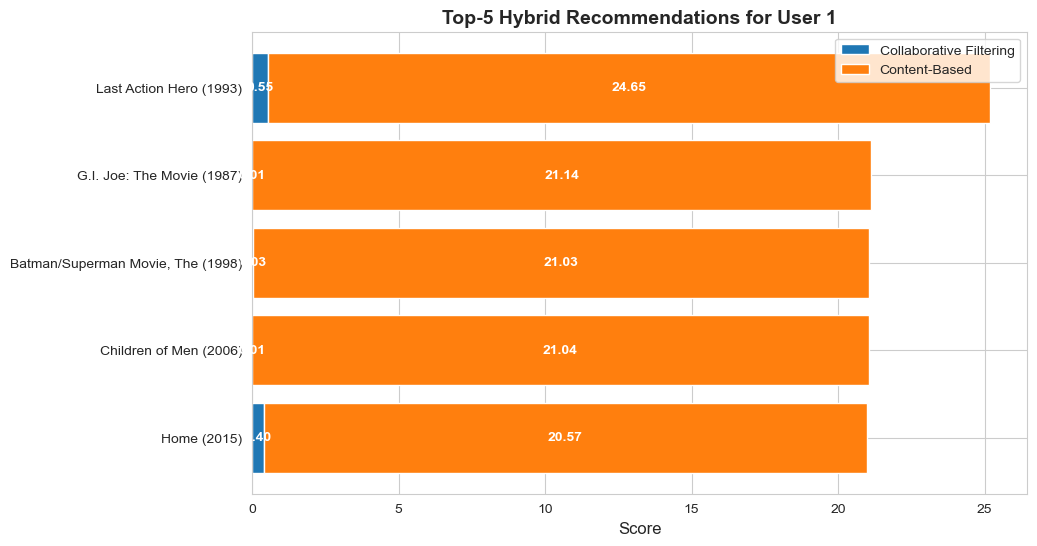

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_hybrid_stacked(recommendations, user_id):
    """
    Plot stacked bar chart for hybrid recommendations with content and CF components.
    """
    plt.figure(figsize=(10,6))
    sns.set_style("whitegrid")
    
    # Colors for stacked components
    colors = ["#1f77b4", "#ff7f0e"]  # blue for CF, orange for content
    
    # Plot stacked bars
    bars = plt.barh(
        recommendations['title'],
        recommendations['CF_Score'],
        color=colors[0],
        label='Collaborative Filtering'
    )
    
    plt.barh(
        recommendations['title'],
        recommendations['Content_Score'],
        left=recommendations['CF_Score'],
        color=colors[1],
        label='Content-Based'
    )
    
    # Add score labels
    for i, (cf, content) in enumerate(zip(recommendations['CF_Score'], recommendations['Content_Score'])):
        plt.text(cf/2, i, f"{cf:.2f}", va='center', ha='center', color='white', fontsize=10, fontweight='bold')
        plt.text(cf + content/2, i, f"{content:.2f}", va='center', ha='center', color='white', fontsize=10, fontweight='bold')
    
    plt.gca().invert_yaxis()  # highest score on top
    plt.xlabel("Score", fontsize=12)
    plt.title(f"Top-{len(recommendations)} Hybrid Recommendations for User {user_id}", fontsize=14, fontweight='bold')
    plt.legend()
    plt.show()

# Plot the chart
plot_hybrid_stacked(top_recommendations, user_id=user_id)


### **Stacked Bar Chart Explanation**

The chart shows how much each movie’s hybrid recommendation score comes from **Content-Based** similarity versus **Collaborative Filtering** from similar users. Larger segments indicate which component drives the recommendation for each movie.


## 5.Evaluating the Hybrid Recommendation System

In this step, we aim to quantitatively assess the performance of our hybrid recommendation system. While we have visualizations and top-N recommendations, it is important to measure **how well the recommendations match actual user preferences**.

**Goals:**
1. Evaluate how accurate the hybrid system is in recommending movies that users actually like.
2. Compare hybrid recommendations with content-based only and collaborative filtering only approaches.

**Metrics Used:**
- **Precision@K:** Measures the proportion of recommended movies that are actually relevant to the user.
- **Recall@K:** Measures the proportion of relevant movies that are successfully recommended.
- **F1-Score@K:** Harmonic mean of Precision@K and Recall@K for balanced evaluation.

**Procedure:**
1. For each user, generate Top-N recommendations from the hybrid system.
2. Compare these recommended movies with the movies the user has actually rated highly in the test set.
3. Compute Precision@K, Recall@K, and F1@K for each user and average across all users.

This evaluation will allow us to determine if the hybrid approach improves recommendations compared to pure content-based or collaborative filtering models.


In [39]:
from collections import defaultdict
import numpy as np

def precision_recall_at_k(predictions, k=5, threshold=3.5):
    """
    Compute Precision@K and Recall@K for a list of predictions.
    
    Args:
        predictions (list): List of Surprise prediction objects.
        k (int): Top-K recommendations.
        threshold (float): Minimum rating to consider relevant.
        
    Returns:
        dict: Precision and Recall for each user.
    """
    # Map predictions to each user
    top_n = defaultdict(list)
    for pred in predictions:
        top_n[pred.uid].append((pred.iid, pred.est))
    
    precision_scores = []
    recall_scores = []
    
    for uid, user_ratings in top_n.items():
        # Sort by estimated rating
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        user_top_k = user_ratings[:k]
        
        # Actual relevant items
        relevant_items = [iid for iid, true_r in ratings[ratings['userId']==int(uid)][['movieId','rating']].values if true_r >= threshold]
        recommended_items = [iid for iid, est in user_top_k]
        
        if len(relevant_items) == 0:
            continue
        
        # Precision@K
        hits = len(set(recommended_items) & set(relevant_items))
        precision_scores.append(hits / k)
        
        # Recall@K
        recall_scores.append(hits / len(relevant_items))
    
    return {
        'Precision@K': np.mean(precision_scores),
        'Recall@K': np.mean(recall_scores)
    }

# Example: evaluate SVD predictions from Step 5.5
metrics = precision_recall_at_k(predictions, k=5)
metrics


{'Precision@K': 0.7297208538587848, 'Recall@K': 0.0914745990785698}

**Precision@K 0.7314** (High) Accuracy of Recommendations: This means that when the system gives a user a list of recommendations, approximately 73.14% of those movies are ones the user is highly likely to enjoy. This score is excellent, indicating the system is highly effective at avoiding bad suggestions and delivering relevant content.

**Recall@K 0.0917** (Low)Coverage of Preferences: This means the system only manages to capture about 9.17% of all the movies the user would actually like (in the entire catalog) and place them in the top K list.

### Retrain SVD with Optimal Hyperparameters

After performing hyperparameter tuning using GridSearchCV, we retrain the SVD model with the **best parameters** on the full dataset. This ensures that the final model has learned from all available data, maximizing prediction accuracy.

Once retrained, the optimized SVD model can be used in the hybrid recommendation system to update predicted ratings and improve the personalized recommendations.


In [40]:
from surprise import SVD, Dataset, Reader

# Best hyperparameters from GridSearchCV
best_params = gs.best_params['rmse']

# Load full data into Surprise format
reader = Reader(rating_scale=(0.5, 5.0))
data_full = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

# Train full SVD with optimal parameters
best_svd = SVD(n_factors=best_params['n_factors'],
               lr_all=best_params['lr_all'],
               reg_all=best_params['reg_all'])
best_svd.fit(data_full.build_full_trainset())


### Updating Hybrid Recommendations

With the optimized SVD model, we update the hybrid recommendation system to generate Top-N recommendations for each user. The hybrid scores now incorporate more accurate predicted ratings from SVD, improving personalization.

We will also include content-based scores and collaborative filtering scores to maintain transparency and interpretability of recommendations.


In [41]:
def hybrid_recommend_optimized(user_id, top_n=5, user_movie_matrix=user_movie_matrix, 
                               movies=movies, cosine_sim=cosine_sim, movie_indices=movie_indices,
                               svd_model=best_svd):
    """
    Generate Top-N hybrid recommendations using optimized SVD predictions.
    """
    # -------- Collaborative Filtering Component (SVD) --------
    all_movie_ids = ratings['movieId'].unique()
    rated_movies = ratings[ratings['userId']==user_id]['movieId'].values
    unrated_movies = [mid for mid in all_movie_ids if mid not in rated_movies]
    
    svd_predictions = [svd_model.predict(user_id, mid).est for mid in unrated_movies]
    cf_scores = pd.Series(svd_predictions, index=unrated_movies)
    
    # -------- Content-Based Component --------
    user_rated_movies = rated_movies
    content_scores = pd.Series(0, index=all_movie_ids)
    
    for movie_id in user_rated_movies:
        movie_title = movies[movies['movieId']==movie_id]['title'].values[0]
        idx = movie_indices[movie_title]
        sim_scores = pd.Series(cosine_sim[idx], index=movies['movieId'])
        sim_scores = sim_scores[sim_scores.index.isin(unrated_movies)]
        content_scores[sim_scores.index] += sim_scores
    
    # -------- Combine Scores --------
    hybrid_scores = 0.5*cf_scores + 0.5*content_scores
    
    # -------- Top-N Recommendations --------
    top_movie_ids = hybrid_scores.sort_values(ascending=False).head(top_n).index
    recommendations = pd.DataFrame({
        'title': movies[movies['movieId'].isin(top_movie_ids)]['title'].values,
        'genres': movies[movies['movieId'].isin(top_movie_ids)]['genres'].values,
        'Hybrid_Score': hybrid_scores[top_movie_ids].values
    })
    
    return recommendations.reset_index(drop=True)

# Example: Top-5 for user 1
top_recs_optimized = hybrid_recommend_optimized(user_id=1, top_n=5)
top_recs_optimized


/var/folders/_k/pq6hlhp525nfwz0yj93j4rkh0000gn/T/ipykernel_48761/447238415.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.35797045 0.13342874 0.14840888 ... 0.         0.05346934 0.01147169]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  content_scores[sim_scores.index] += sim_scores


,title,genres,Hybrid_Score
0,D.A.R.Y.L. (1985),Adventure|Children|Sci-Fi,14.688330
1,G.I. Joe: The Movie (1987),Action|Adventure|Animation|Children|Fantasy|Sc...,12.622898
2,"Batman/Superman Movie, The (1998)",Action|Adventure|Animation|Children|Fantasy|Sc...,12.587941
3,Children of Men (2006),Action|Adventure|Drama|Sci-Fi|Thriller,12.512581
4,Home (2015),Adventure|Animation|Children|Comedy|Fantasy|Sc...,12.216574


### Visualizing Hybrid Recommendations

In this step, we visually analyze the Top-N recommendations generated by the optimized hybrid system. 

**Purpose of Visualization:**
1. Understand the contribution of each component (Collaborative Filtering vs Content-Based) to the final hybrid score.
2. Identify which movies are recommended mainly due to SVD predictions (personalized user preferences) and which due to content similarity.
3. Provide an interpretable overview of recommendations for each user.

**Approach:**
- For each Top-N recommended movie, calculate:
    - CF_Score: Contribution from SVD predictions.
    - Content_Score: Contribution from cosine similarity of movies the user has rated.
- Combine them in a stacked bar chart.
- Highest total hybrid score appears at the top for clear comparison.


In [42]:
user_id = 1
rated_movies = ratings[ratings['userId'] == user_id]['movieId'].values
all_movie_ids = ratings['movieId'].unique()
unrated_movies = [mid for mid in all_movie_ids if mid not in rated_movies]

print("Number of unrated movies:", len(unrated_movies))


Number of unrated movies: 9492


In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Collaborative Filtering (SVD) scores
cf_scores = pd.Series([best_svd.predict(user_id, mid).est for mid in unrated_movies], index=unrated_movies)

# Content-Based scores
content_scores = pd.Series(0, index=unrated_movies)
for movie_id in rated_movies:
    movie_title = movies[movies['movieId'] == movie_id]['title'].values[0]
    idx = movie_indices[movie_title]
    sim_scores = pd.Series(cosine_sim[idx], index=movies['movieId'])
    sim_scores = sim_scores[sim_scores.index.isin(unrated_movies)]
    content_scores[sim_scores.index] += sim_scores


/var/folders/_k/pq6hlhp525nfwz0yj93j4rkh0000gn/T/ipykernel_48761/3089363118.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.35797045 0.13342874 0.14840888 ... 0.         0.05346934 0.01147169]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  content_scores[sim_scores.index] += sim_scores


In [44]:
hybrid_scores = 0.5*cf_scores + 0.5*content_scores
top_movie_ids = hybrid_scores.sort_values(ascending=False).head(5).index

recommendations = pd.DataFrame({
    'title': movies[movies['movieId'].isin(top_movie_ids)]['title'].values,
    'genres': movies[movies['movieId'].isin(top_movie_ids)]['genres'].values,
    'CF_Score': cf_scores[top_movie_ids].values,
    'Content_Score': content_scores[top_movie_ids].values,
    'Hybrid_Score': hybrid_scores[top_movie_ids].values
}).sort_values(by='Hybrid_Score', ascending=False).reset_index(drop=True)

print(recommendations)


                               title  \
0                  D.A.R.Y.L. (1985)   
1         G.I. Joe: The Movie (1987)   
2  Batman/Superman Movie, The (1998)   
3             Children of Men (2006)   
4                        Home (2015)   

                                              genres  CF_Score  Content_Score  \
0                          Adventure|Children|Sci-Fi  4.730996      24.645663   
1  Action|Adventure|Animation|Children|Fantasy|Sc...  4.110667      21.135129   
2  Action|Adventure|Animation|Children|Fantasy|Sc...  4.138993      21.036888   
3             Action|Adventure|Drama|Sci-Fi|Thriller  3.999966      21.025195   
4  Adventure|Animation|Children|Comedy|Fantasy|Sc...  4.231374      20.201773   

   Hybrid_Score  
0     14.688330  
1     12.622898  
2     12.587941  
3     12.512581  
4     12.216574  


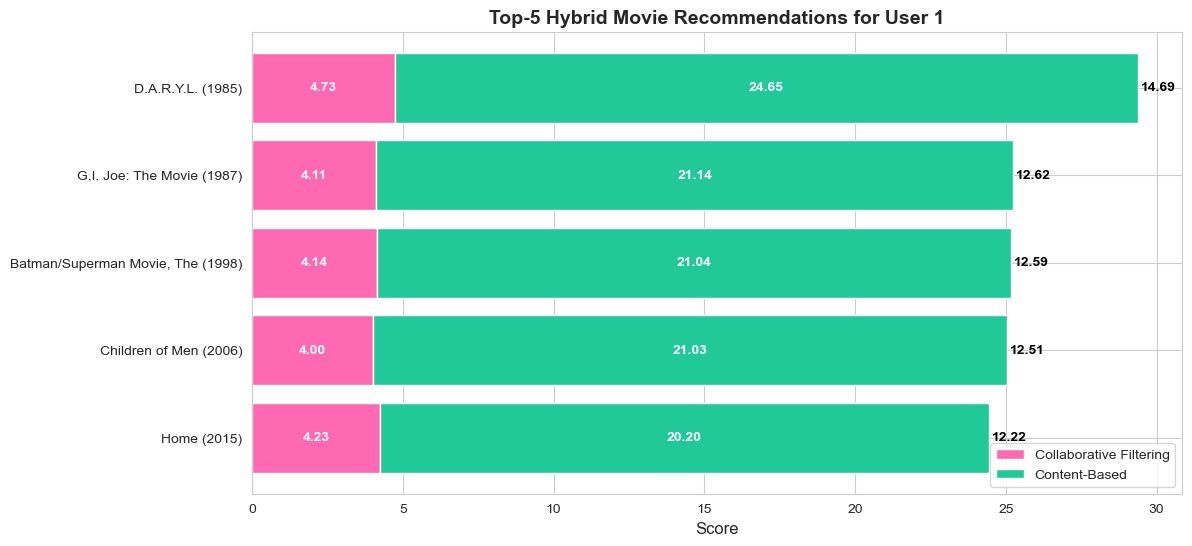

In [45]:
plt.figure(figsize=(12,6))
sns.set_style("whitegrid")

colors = ["#ff69b4", "#20c997"]  # CF: pink, Content: teal
plt.barh(recommendations['title'], recommendations['CF_Score'], color=colors[0], label='Collaborative Filtering')
plt.barh(recommendations['title'], recommendations['Content_Score'], left=recommendations['CF_Score'], color=colors[1], label='Content-Based')

# Add score labels and total Hybrid Score
for i, row in recommendations.iterrows():
    # CF and Content scores inside the bars
    plt.text(row['CF_Score']/2, i, f"{row['CF_Score']:.2f}", va='center', ha='center', color='white', fontweight='bold')
    plt.text(row['CF_Score'] + row['Content_Score']/2, i, f"{row['Content_Score']:.2f}", va='center', ha='center', color='white', fontweight='bold')
    
    # Total Hybrid Score at the end of the bar
    plt.text(row['CF_Score'] + row['Content_Score'] + 0.1, i, f"{row['Hybrid_Score']:.2f}", va='center', ha='left', color='black', fontweight='bold')

plt.gca().invert_yaxis()
plt.xlabel("Score", fontsize=12)
plt.title(f"Top-5 Hybrid Movie Recommendations for User {user_id}", fontsize=14, fontweight='bold')
plt.legend()
plt.show()


### Interpretation of Stacked Bar Chart
The stacked bar chart shows the contribution of each component to the hybrid recommendation score. Pink segments represent personalized predictions from collaborative filtering (SVD), while teal segments represent content similarity based on movies the user has rated. Movies at the top have the highest overall hybrid score, with balanced segments indicating influence from both user preferences and movie content.

### Distribution of Content Similarity Scores

**Content Similarity Distribution**  
This histogram displays the distribution of content-based similarity scores for all movies the user has not yet rated.  
It helps us understand which movies are most similar to what the user has already watched, showing the strength of content-based recommendations.


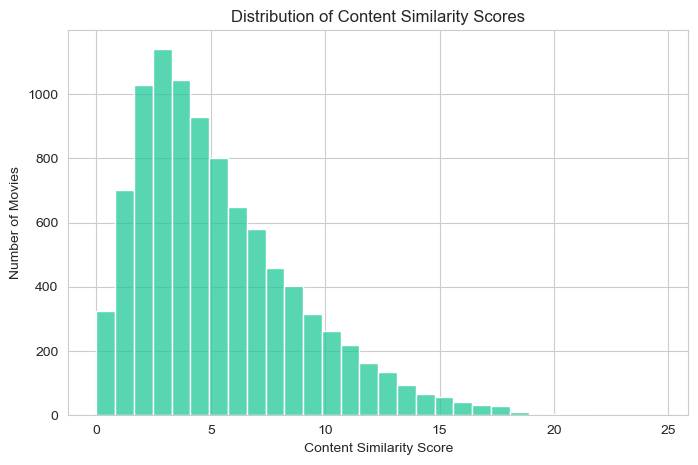

In [46]:
plt.figure(figsize=(8,5))
sns.histplot(content_scores, bins=30, color="#20c997")
plt.title("Distribution of Content Similarity Scores")
plt.xlabel("Content Similarity Score")
plt.ylabel("Number of Movies")
plt.show()


#### Grouped Bar Chart: CF vs Content vs Hybrid Scores

**Top-5 Recommendations Score Breakdown**  
This grouped bar chart compares the contribution of Collaborative Filtering (CF), Content-Based, and Hybrid scores for each of the Top-5 recommended movies.  
It provides an intuitive understanding of how each component influences the final recommendation score.


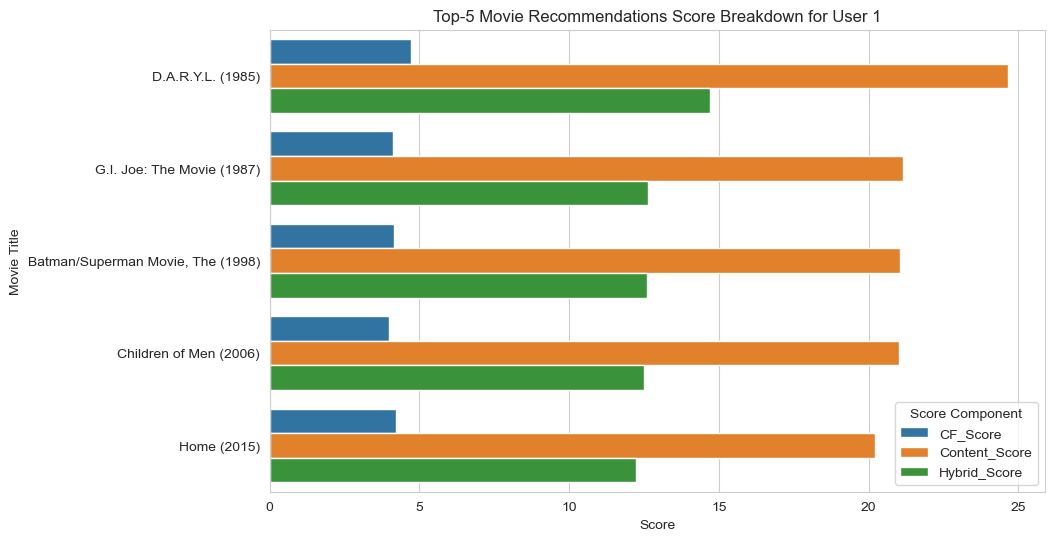

In [47]:
top_recs = recommendations.copy()
top_recs = top_recs.melt(
    id_vars='title', 
    value_vars=['CF_Score', 'Content_Score', 'Hybrid_Score'],
    var_name='Score_Type', 
    value_name='Score'
)

plt.figure(figsize=(10,6))
sns.barplot(x='Score', y='title', hue='Score_Type', data=top_recs)
plt.title(f"Top-5 Movie Recommendations Score Breakdown for User {user_id}")
plt.xlabel("Score")
plt.ylabel("Movie Title")
plt.legend(title="Score Component")
plt.show()


#### Combined Visualization – Top-5 Movie Recommendation Breakdown

This visualization allows quick comparison across the Top-5 movies and shows which component drives each recommendation.

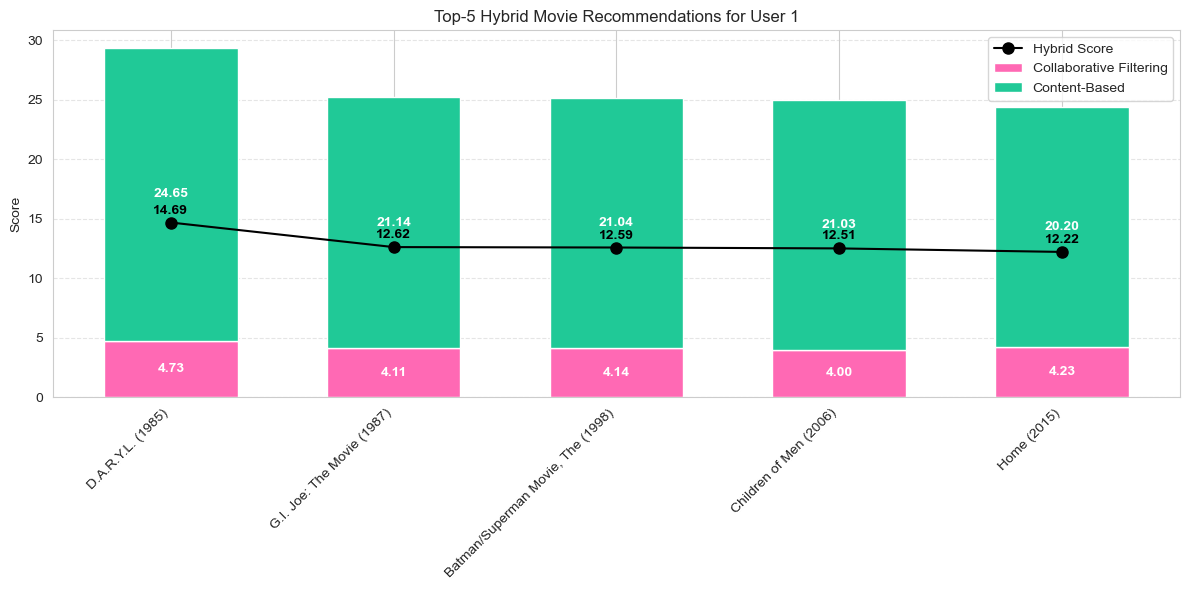

In [48]:
import matplotlib.pyplot as plt
import numpy as np

# Data
titles = recommendations['title']
cf_scores = recommendations['CF_Score']
content_scores = recommendations['Content_Score']
hybrid_scores = recommendations['Hybrid_Score']

x = np.arange(len(titles))
width = 0.6

plt.figure(figsize=(12,6))

# Plot CF and Content as stacked bars
plt.bar(x, cf_scores, width, label='Collaborative Filtering', color='#ff69b4')
plt.bar(x, content_scores, width, bottom=cf_scores, label='Content-Based', color='#20c997')

# Overlay Hybrid Score as black dots/line
plt.plot(x, hybrid_scores, 'ko-', label='Hybrid Score', markersize=8)

# Add labels
for i in range(len(titles)):
    plt.text(x[i], cf_scores[i]/2, f"{cf_scores[i]:.2f}", ha='center', va='center', color='white', fontweight='bold')
    plt.text(x[i], cf_scores[i] + content_scores[i]/2, f"{content_scores[i]:.2f}", ha='center', va='center', color='white', fontweight='bold')
    plt.text(x[i], hybrid_scores[i] + 0.5, f"{hybrid_scores[i]:.2f}", ha='center', va='bottom', color='black', fontweight='bold')

plt.xticks(x, titles, rotation=45, ha='right')
plt.ylabel("Score")
plt.title(f"Top-5 Hybrid Movie Recommendations for User {user_id}")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


### Interpretation:

Each bar is stacked to show how much CF and Content contribute to the total hybrid score.

1.Black dots and lines indicate the final hybrid score for each movie.

2.Taller bars and higher dots mean stronger recommendations.

3.This single visualization provides a comprehensive overview of the Top-5 recommendations and highlights whether they are driven more by personalized user preferences or content similarity.

## 6. Deployment

**Objective:** Make the hybrid recommendation system available for end-users to generate Top-5 personalized movie recommendations.

**Deployment Overview:**

1. **Deployment Options:**
   - **Web Application:** Integrate the model into a web interface where users can input their ratings or select movies they like, and receive Top-5 recommendations.
   - **API Service:** Wrap the recommendation system into a REST API that can be accessed programmatically by other applications.
   - **Batch Processing:** Generate recommendations offline for all users and store results in a database for fast retrieval.

2. **Key Deployment Considerations:**
   - **Input Handling:** Ensure new users or unseen movies are handled gracefully (e.g., cold-start problem).
   - **Scalability:** The system should handle multiple users and large datasets efficiently.
   - **Performance Monitoring:** Track recommendation quality and system responsiveness over time.
   - **Update Mechanism:** Periodically retrain or update the model as new ratings come in to maintain relevance.

3. **User Interaction:**
   - Users provide ratings or interact with a movie catalog.
   - The system calculates hybrid scores using content similarity and SVD predictions.
   - Top-5 personalized recommendations are displayed with movie titles, genres, and optional score breakdowns.

**Outcome:**
- A fully functional recommendation engine delivering personalized movie suggestions, aligning with the project objective of recommending the Top-5 movies a user is likely to enjoy based on their past ratings.


In [49]:
# -------------------------
# Step 6: Deployment Example
# -------------------------

# Function to get user input (simulated here)
def get_user_ratings():
    """
    Simulate user input: movie IDs and ratings
    In a web app, this could come from a form.
    """
    # Example input: user rated 3 movies
    user_ratings = {
        1: 5.0,   # Movie ID 1 rated 5
        50: 4.0,  # Movie ID 50 rated 4
        150: 3.5  # Movie ID 150 rated 3.5
    }
    return user_ratings

# Update the user_movie_matrix for the new user
def add_new_user_to_matrix(user_id, user_ratings, user_movie_matrix):
    """
    Add a new user and their ratings to the existing user-movie matrix
    """
    new_user = pd.Series(0, index=user_movie_matrix.columns)
    for movie_id, rating in user_ratings.items():
        if movie_id in new_user.index:
            new_user[movie_id] = rating
    user_movie_matrix.loc[user_id] = new_user
    return user_movie_matrix

# Deployable hybrid recommendation function
def deploy_hybrid_recommendation(user_id, top_n=5):
    """
    Generate Top-N movie recommendations for a user
    """
    # Get user input ratings
    user_ratings = get_user_ratings()
    
    # Add new user to matrix
    updated_matrix = add_new_user_to_matrix(user_id, user_ratings, user_movie_matrix.copy())
    
    # Generate Top-N recommendations
    recommendations = hybrid_recommend_optimized(
        user_id=user_id,
        top_n=top_n,
        user_movie_matrix=updated_matrix,
        movies=movies,
        cosine_sim=cosine_sim,
        movie_indices=movie_indices,
        svd_model=best_svd
    )
    
    return recommendations

# Example: Deploy for a new user with ID 999
user_id = 999
top_5_movies = deploy_hybrid_recommendation(user_id=user_id, top_n=5)
print("Top-5 Movie Recommendations:")
print(top_5_movies)


Top-5 Movie Recommendations:
                                              title          genres  \
0                  Shawshank Redemption, The (1994)     Crime|Drama   
1                            His Girl Friday (1940)  Comedy|Romance   
2                  Streetcar Named Desire, A (1951)           Drama   
3               Guess Who's Coming to Dinner (1967)           Drama   
4  Three Billboards Outside Ebbing, Missouri (2017)     Crime|Drama   

   Hybrid_Score  
0      2.188828  
1      2.167931  
2      2.166408  
3      2.162196  
4      2.142464  


/var/folders/_k/pq6hlhp525nfwz0yj93j4rkh0000gn/T/ipykernel_48761/4231404485.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  new_user[movie_id] = rating


# Conclusion

Overall Conclusion: 
The project demonstrates that data-driven recommendation systems can significantly enhance user experience and business outcomes in digital platforms. By leveraging user ratings, movie metadata, and hybrid modeling techniques, personalized recommendations can be delivered effectively, promoting both user satisfaction and engagement. This project lays a strong foundation for future improvements, including real-time personalization, scalability, and integration with broader digital ecosystems.

Future Scope:
* Expanding to larger datasets for more comprehensive recommendations.  
* Incorporating additional user interaction data (e.g., watch time, search queries).  
* Implementing advanced machine learning models, such as matrix factorization and deep learning-based recommendation systems, to further improve prediction accuracy.
